In [127]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta

In [128]:
# %pip install peewee
# %pip install statsmodels
# %pip install pandas_datareader
# %pip install pandas_ta
# %pip install PyPortfolioOpt

# 1. Data Preparation

In [129]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500

symbol_list = sp500['Symbol'].unique().tolist()
symbol_list = [x.replace('.', '-') for x in symbol_list]

end_date = '2024-10-04'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*10)

df = yf.download(tickers=symbol_list, start=start_date, end=end_date)

df = df.stack(future_stack=True)
df.index.names = ["Date", "Ticker"]
df

[*********************100%***********************]  503 of 503 completed


Price                              Adj Close       Close        High  \
Date                      Ticker                                       
2014-10-07 00:00:00+00:00 A        36.209541   39.341915   40.293278   
                          AAPL     21.920212   24.687500   25.030001   
                          ABBV     37.473686   56.650002   57.599998   
                          ABNB           NaN         NaN         NaN   
                          ABT      34.245220   41.459999   42.180000   
...                                      ...         ...         ...   
2024-10-03 00:00:00+00:00 XYL     133.059998  133.059998  134.089996   
                          YUM     137.210007  137.210007  138.660004   
                          ZBH     104.190002  104.190002  105.750000   
                          ZBRA    363.890015  363.890015  368.170013   
                          ZTS     190.990005  190.990005  192.330002   

Price                                    Low        Open       Volume  
Date                      Ticker                                       
2014-10-07 00:00:00+00:00 A        39.341915   40.236053    2117271.0  
                          AAPL     24.682501   24.857500  168376800.0  
                          ABBV     56.509998   57.599998    8923500.0  
                          ABNB           NaN         NaN          NaN  
                          ABT      41.450001   42.090000    5178200.0  
...                                      ...         ...          ...  
2024-10-03 00:00:00+00:00 XYL     131.979996  134.089996    1007800.0  
                          YUM     137.199997  138.639999    1993400.0  
                          ZBH     103.820000  105.320000    1910100.0  
                          ZBRA    362.619995  365.989990     302800.0  
                          ZTS     190.000000  191.889999    1325000.0  

[1265045 rows x 6 columns]

# 2. Calculation of Features and Indicators

## 2.1. Volatilities
* Close-to-close Volatility
$$\sigma_{cl} = \sqrt{\frac{1}{T-1} \sum_{t=1}^T (r_t - \bar{r})^2}$$

Where, \
T = Number of days in the sample period \
$r_t$ = Return on Day t \
$\bar{r}$ = mean return 

In [130]:
#Close to Close Volatility
# num_comp = 503
# days = df.shape[0]/num_comp
# mean_ret = 0
# ctc_vol = sqrt((1/days -1) * (1))

* Parkinson Volatility

* Garman-Klass Volatiltiy
$$\sigma_{GK} = \sqrt{\frac{1}{T} \sum_{t=1}^T \frac{1}{2} ln(\frac{h_t}{l_t})^2 - (2ln(2) - 1)ln(\frac{c_t}{o_t})^2}$$

In [131]:
df['Garman_Klass_Volatility'] = 0.5*(np.log(df['High']) - np.log(df['Low']))**2 - (2*np.log(2) - 1)*(np.log(df['Adj Close'])- np.log(df['Open']))**2
df

Price                              Adj Close       Close        High  \
Date                      Ticker                                       
2014-10-07 00:00:00+00:00 A        36.209541   39.341915   40.293278   
                          AAPL     21.920212   24.687500   25.030001   
                          ABBV     37.473686   56.650002   57.599998   
                          ABNB           NaN         NaN         NaN   
                          ABT      34.245220   41.459999   42.180000   
...                                      ...         ...         ...   
2024-10-03 00:00:00+00:00 XYL     133.059998  133.059998  134.089996   
                          YUM     137.210007  137.210007  138.660004   
                          ZBH     104.190002  104.190002  105.750000   
                          ZBRA    363.890015  363.890015  368.170013   
                          ZTS     190.990005  190.990005  192.330002   

Price                                    Low        Open       Volume  \
Date                      Ticker                                        
2014-10-07 00:00:00+00:00 A        39.341915   40.236053    2117271.0   
                          AAPL     24.682501   24.857500  168376800.0   
                          ABBV     56.509998   57.599998    8923500.0   
                          ABNB           NaN         NaN          NaN   
                          ABT      41.450001   42.090000    5178200.0   
...                                      ...         ...          ...   
2024-10-03 00:00:00+00:00 XYL     131.979996  134.089996    1007800.0   
                          YUM     137.199997  138.639999    1993400.0   
                          ZBH     103.820000  105.320000    1910100.0   
                          ZBRA    362.619995  365.989990     302800.0   
                          ZTS     190.000000  191.889999    1325000.0   

Price                             Garman_Klass_Volatility  
Date                      Ticker                           
2014-10-07 00:00:00+00:00 A                     -0.004009  
                          AAPL                  -0.006011  
                          ABBV                  -0.071205  
                          ABNB                        NaN  
                          ABT                   -0.016282  
...                                                   ...  
2024-10-03 00:00:00+00:00 XYL                    0.000103  
                          YUM                    0.000014  
                          ZBH                    0.000125  
                          ZBRA                   0.000103  
                          ZTS                    0.000066  

[1265045 rows x 7 columns]

* Rogers-Satchell Volatility

* Yang-Zhang Volatility

RSI

In [132]:
df['RSI'] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

Bollinger Bands

In [133]:
df['bb_low'] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])


ATR - Average True Range

In [134]:
def calc_atr(stock):
    atr = pandas_ta.atr(high=stock['High'], low=stock['Low'], close=stock['Close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['ATR'] = df.groupby(level=1, group_keys=False).apply(calc_atr)

df

Price                              Adj Close       Close        High  \
Date                      Ticker                                       
2014-10-07 00:00:00+00:00 A        36.209541   39.341915   40.293278   
                          AAPL     21.920212   24.687500   25.030001   
                          ABBV     37.473686   56.650002   57.599998   
                          ABNB           NaN         NaN         NaN   
                          ABT      34.245220   41.459999   42.180000   
...                                      ...         ...         ...   
2024-10-03 00:00:00+00:00 XYL     133.059998  133.059998  134.089996   
                          YUM     137.210007  137.210007  138.660004   
                          ZBH     104.190002  104.190002  105.750000   
                          ZBRA    363.890015  363.890015  368.170013   
                          ZTS     190.990005  190.990005  192.330002   

Price                                    Low        Open       Volume  \
Date                      Ticker                                        
2014-10-07 00:00:00+00:00 A        39.341915   40.236053    2117271.0   
                          AAPL     24.682501   24.857500  168376800.0   
                          ABBV     56.509998   57.599998    8923500.0   
                          ABNB           NaN         NaN          NaN   
                          ABT      41.450001   42.090000    5178200.0   
...                                      ...         ...          ...   
2024-10-03 00:00:00+00:00 XYL     131.979996  134.089996    1007800.0   
                          YUM     137.199997  138.639999    1993400.0   
                          ZBH     103.820000  105.320000    1910100.0   
                          ZBRA    362.619995  365.989990     302800.0   
                          ZTS     190.000000  191.889999    1325000.0   

Price                             Garman_Klass_Volatility        RSI  \
Date                      Ticker                                       
2014-10-07 00:00:00+00:00 A                     -0.004009        NaN   
                          AAPL                  -0.006011        NaN   
                          ABBV                  -0.071205        NaN   
                          ABNB                        NaN        NaN   
                          ABT                   -0.016282        NaN   
...                                                   ...        ...   
2024-10-03 00:00:00+00:00 XYL                    0.000103  49.330137   
                          YUM                    0.000014  55.382175   
                          ZBH                    0.000125  39.506848   
                          ZBRA                   0.000103  59.098207   
                          ZTS                    0.000066  53.496868   

Price                               bb_low    bb_mid   bb_high       ATR  
Date                      Ticker                                          
2014-10-07 00:00:00+00:00 A            NaN       NaN       NaN       NaN  
                          AAPL         NaN       NaN       NaN       NaN  
                          ABBV         NaN       NaN       NaN       NaN  
                          ABNB         NaN       NaN       NaN       NaN  
                          ABT          NaN       NaN       NaN       NaN  
...                                    ...       ...       ...       ...  
2024-10-03 00:00:00+00:00 XYL     4.860378  4.895486  4.930595  0.830259  
                          YUM     4.861648  4.908749  4.955849  0.908101  
                          ZBH     4.652283  4.674293  4.696304 -0.731980  
                          ZBRA    5.781280  5.870433  5.959586  0.244182  
                          ZTS     5.246796  5.267334  5.287872  0.678618  

[1265045 rows x 12 columns]

MACD - Moving Average Convergence/Divergence

In [135]:
def calc_macd(close):
    if len(close) - close.isna().sum() < 20:
        return pd.Series([np.nan]*len(close))
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())


df['macd'] = df.groupby(level=1, group_keys=False)['Adj Close'].apply(calc_macd)
df

Price                              Adj Close       Close        High  \
Date                      Ticker                                       
2014-10-07 00:00:00+00:00 A        36.209541   39.341915   40.293278   
                          AAPL     21.920212   24.687500   25.030001   
                          ABBV     37.473686   56.650002   57.599998   
                          ABNB           NaN         NaN         NaN   
                          ABT      34.245220   41.459999   42.180000   
...                                      ...         ...         ...   
2024-10-03 00:00:00+00:00 XYL     133.059998  133.059998  134.089996   
                          YUM     137.210007  137.210007  138.660004   
                          ZBH     104.190002  104.190002  105.750000   
                          ZBRA    363.890015  363.890015  368.170013   
                          ZTS     190.990005  190.990005  192.330002   

Price                                    Low        Open       Volume  \
Date                      Ticker                                        
2014-10-07 00:00:00+00:00 A        39.341915   40.236053    2117271.0   
                          AAPL     24.682501   24.857500  168376800.0   
                          ABBV     56.509998   57.599998    8923500.0   
                          ABNB           NaN         NaN          NaN   
                          ABT      41.450001   42.090000    5178200.0   
...                                      ...         ...          ...   
2024-10-03 00:00:00+00:00 XYL     131.979996  134.089996    1007800.0   
                          YUM     137.199997  138.639999    1993400.0   
                          ZBH     103.820000  105.320000    1910100.0   
                          ZBRA    362.619995  365.989990     302800.0   
                          ZTS     190.000000  191.889999    1325000.0   

Price                             Garman_Klass_Volatility        RSI  \
Date                      Ticker                                       
2014-10-07 00:00:00+00:00 A                     -0.004009        NaN   
                          AAPL                  -0.006011        NaN   
                          ABBV                  -0.071205        NaN   
                          ABNB                        NaN        NaN   
                          ABT                   -0.016282        NaN   
...                                                   ...        ...   
2024-10-03 00:00:00+00:00 XYL                    0.000103  49.330137   
                          YUM                    0.000014  55.382175   
                          ZBH                    0.000125  39.506848   
                          ZBRA                   0.000103  59.098207   
                          ZTS                    0.000066  53.496868   

Price                               bb_low    bb_mid   bb_high       ATR  \
Date                      Ticker                                           
2014-10-07 00:00:00+00:00 A            NaN       NaN       NaN       NaN   
                          AAPL         NaN       NaN       NaN       NaN   
                          ABBV         NaN       NaN       NaN       NaN   
                          ABNB         NaN       NaN       NaN       NaN   
                          ABT          NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
2024-10-03 00:00:00+00:00 XYL     4.860378  4.895486  4.930595  0.830259   
                          YUM     4.861648  4.908749  4.955849  0.908101   
                          ZBH     4.652283  4.674293  4.696304 -0.731980   
                          ZBRA    5.781280  5.870433  5.959586  0.244182   
                          ZTS     5.246796  5.267334  5.287872  0.678618   

Price                                 macd  
Date                      Ticker            
2014-10-07 00:00:00+00:00 A            NaN  
                          AAPL         NaN  
       

Dollar-Volume

In [136]:
df['Dollar-Volume'] = df['Volume']*df['Adj Close']/1e6
df

Price                              Adj Close       Close        High  \
Date                      Ticker                                       
2014-10-07 00:00:00+00:00 A        36.209541   39.341915   40.293278   
                          AAPL     21.920212   24.687500   25.030001   
                          ABBV     37.473686   56.650002   57.599998   
                          ABNB           NaN         NaN         NaN   
                          ABT      34.245220   41.459999   42.180000   
...                                      ...         ...         ...   
2024-10-03 00:00:00+00:00 XYL     133.059998  133.059998  134.089996   
                          YUM     137.210007  137.210007  138.660004   
                          ZBH     104.190002  104.190002  105.750000   
                          ZBRA    363.890015  363.890015  368.170013   
                          ZTS     190.990005  190.990005  192.330002   

Price                                    Low        Open       Volume  \
Date                      Ticker                                        
2014-10-07 00:00:00+00:00 A        39.341915   40.236053    2117271.0   
                          AAPL     24.682501   24.857500  168376800.0   
                          ABBV     56.509998   57.599998    8923500.0   
                          ABNB           NaN         NaN          NaN   
                          ABT      41.450001   42.090000    5178200.0   
...                                      ...         ...          ...   
2024-10-03 00:00:00+00:00 XYL     131.979996  134.089996    1007800.0   
                          YUM     137.199997  138.639999    1993400.0   
                          ZBH     103.820000  105.320000    1910100.0   
                          ZBRA    362.619995  365.989990     302800.0   
                          ZTS     190.000000  191.889999    1325000.0   

Price                             Garman_Klass_Volatility        RSI  \
Date                      Ticker                                       
2014-10-07 00:00:00+00:00 A                     -0.004009        NaN   
                          AAPL                  -0.006011        NaN   
                          ABBV                  -0.071205        NaN   
                          ABNB                        NaN        NaN   
                          ABT                   -0.016282        NaN   
...                                                   ...        ...   
2024-10-03 00:00:00+00:00 XYL                    0.000103  49.330137   
                          YUM                    0.000014  55.382175   
                          ZBH                    0.000125  39.506848   
                          ZBRA                   0.000103  59.098207   
                          ZTS                    0.000066  53.496868   

Price                               bb_low    bb_mid   bb_high       ATR  \
Date                      Ticker                                           
2014-10-07 00:00:00+00:00 A            NaN       NaN       NaN       NaN   
                          AAPL         NaN       NaN       NaN       NaN   
                          ABBV         NaN       NaN       NaN       NaN   
                          ABNB         NaN       NaN       NaN       NaN   
                          ABT          NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
2024-10-03 00:00:00+00:00 XYL     4.860378  4.895486  4.930595  0.830259   
                          YUM     4.861648  4.908749  4.955849  0.908101   
                          ZBH     4.652283  4.674293  4.696304 -0.731980   
                          ZBRA    5.781280  5.870433  5.959586  0.244182   
                          ZTS     5.246796  5.267334  5.287872  0.678618   

Price                                 macd  Dollar-Volume  
Date                      Ticker                           
2014-10-07 00:00:00+00:00 A            NaN      76.665412  
       

# 3. Aggregate to monthly level and filter top 150 most liquid stocks
* To reduce training time and experiment with features, convert business daily data to monthly frequency

In [137]:
last_cols = [c for c in df.columns.unique(0) if c not in ['Dollar-Volume', 'Volume', 'High', 'Low', 'Open', 'Close']]

data = (pd.concat([df.unstack('Ticker')['Dollar-Volume']
                   .resample('ME').mean().stack('Ticker')
                   .to_frame('Dollar-Volume'),df.unstack()[last_cols].resample('ME').last().stack('Ticker')], axis=1)
                   ).dropna()

data

C:\Users\Ronan\AppData\Local\Temp\ipykernel_316\3563761502.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .to_frame('Dollar-Volume'),df.unstack()[last_cols].resample('ME').last().stack('Ticker')], axis=1)


Dollar-Volume   Adj Close  \
Date                      Ticker                              
2014-11-30 00:00:00+00:00 A          112.789815   39.337078   
                          AAPL      4371.096206   26.514172   
                          ABBV       276.108336   46.116951   
                          ABT        152.871672   36.959782   
                          ACGL        27.891787   19.106667   
...                                         ...         ...   
2024-10-31 00:00:00+00:00 XYL        146.107029  133.059998   
                          YUM        249.816813  137.210007   
                          ZBH        174.133466  104.190002   
                          ZBRA       115.199449  363.890015   
                          ZTS        289.924995  190.990005   

                                  Garman_Klass_Volatility        RSI  \
Date                      Ticker                                       
2014-11-30 00:00:00+00:00 A                     -0.002615  67.954836   
                          AAPL                  -0.005261  80.558209   
                          ABBV                  -0.062678  76.357662   
                          ABT                   -0.013124  64.020257   
                          ACGL                   0.000021  60.878934   
...                                                   ...        ...   
2024-10-31 00:00:00+00:00 XYL                    0.000103  49.330137   
                          YUM                    0.000014  55.382175   
                          ZBH                    0.000125  39.506848   
                          ZBRA                   0.000103  59.098207   
                          ZTS                    0.000066  53.496868   

                                    bb_low    bb_mid   bb_high       ATR  \
Date                      Ticker                                           
2014-11-30 00:00:00+00:00 A       3.624898  3.665358  3.705817 -1.124467   
                          AAPL    3.196737  3.264268  3.331800 -1.023267   
                          ABBV    3.723635  3.789364  3.855094 -1.077517   
                          ABT     3.606485  3.622894  3.639303 -1.151583   
                          ACGL    2.986044  2.997348  3.008653 -1.228324   
...                                    ...       ...       ...       ...   
2024-10-31 00:00:00+00:00 XYL     4.860378  4.895486  4.930595  0.830259   
                          YUM     4.861648  4.908749  4.955849  0.908101   
                          ZBH     4.652283  4.674293  4.696304 -0.731980   
                          ZBRA    5.781280  5.870433  5.959586  0.244182   
                          ZTS     5.246796  5.267334  5.287872  0.678618   

                                      macd  
Date                      Ticker            
2014-11-30 00:00:00+00:00 A       0.404653  
                          AAPL    0.203338  
                          ABBV    0.913270  
                          ABT     0.272757  
                          ACGL   -0.100377  
...                                    ...  
2024-10-31 00:00:00+00:00 XYL     0.091808  
                          YUM     0.778775  
                          ZBH    -0.415730  
                          ZBRA    1.068525  
                          ZTS     0.695415  

[58558 rows x 9 columns]

Calculate 5 year rolling average of dollar volume

In [138]:
data['Dollar-Volume'] = (data.loc[:,'Dollar-Volume'].unstack('Ticker').rolling(5*12, min_periods=12).mean().stack())
data['Dollar-Volume-Rank'] = (data.groupby('Date')['Dollar-Volume'].rank(ascending=False))

data = data[data['Dollar-Volume-Rank']<150].drop(['Dollar-Volume', 'Dollar-Volume-Rank'], axis=1)
data.xs('2015-10-31 00:00:00+00:00	')


,Adj Close,Garman_Klass_Volatility,RSI,bb_low,bb_mid,bb_high,ATR,macd
Ticker,,,,,,,,
AAPL,26.979689,-0.004941,58.203989,3.227073,3.283135,3.339196,-0.893841,-0.090024
ABBV,40.989498,-0.044602,56.442921,3.562296,3.647407,3.732519,0.456540,-0.572859
ABT,37.989735,-0.011553,58.030773,3.535961,3.607121,3.678281,-0.820269,0.260327
ACN,92.835953,-0.008836,63.019460,4.463377,4.515202,4.567028,-0.906223,0.384691
ADBE,88.660004,0.000138,58.975531,4.412333,4.468043,4.523752,-1.096182,0.038936
...,...,...,...,...,...,...,...,...
WMB,22.951920,-0.102385,43.059397,3.117532,3.209468,3.301405,1.986875,-1.526557
WMT,15.956631,-0.013434,28.818369,2.775446,2.892890,3.010335,-0.962195,-1.381327
WYNN,61.924751,-0.004377,49.795626,4.028058,4.130814,4.233569,0.199256,-0.043779


# 4.Calculate Monthly Returns for different time horizons as features.
* To capture time series dynamics that reflect momentum patterns, etc, compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags

In [139]:
def calc_returns(df):
    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]

    for lag in lags:
        df[f'return_{lag}'] = (df['Adj Close'].pct_change(lag)
                            .pipe(lambda x:x.clip(lower=x.quantile(outlier_cutoff), upper= x.quantile(1-outlier_cutoff)))
                            .add(1).pow(1/lag).sub(1))

    return df

data = data.groupby(level=1, group_keys=False).apply(calc_returns).dropna()
data.index = data.index.set_levels(data.index.levels[0].tz_localize(None), level=0)
data

Adj Close  Garman_Klass_Volatility        RSI    bb_low  \
Date       Ticker                                                             
2016-10-31 AAPL     26.182171                -0.002541  49.891105  3.293123   
           ABBV     39.878788                -0.049190  27.477824  3.744517   
           ABT      34.112488                -0.008074  38.008827  3.549492   
           ACN     102.699379                -0.005388  53.823701  4.628986   
           ADBE    107.510002                 0.000059  53.668382  4.679513   
...                       ...                      ...        ...       ...   
2024-10-31 VRTX    453.549988                 0.000156  39.600515  6.116345   
           VZ       43.835697                -0.000153  60.266783  3.754516   
           WFC      54.980000                 0.000105  48.427271  3.974011   
           WMT      80.430000                 0.000040  63.139382  4.358117   
           XOM     122.580002                 0.000156  61.874866  4.696001   

                     bb_mid   bb_high       ATR      macd  return_1  return_2  \
Date       Ticker                                                               
2016-10-31 AAPL    3.322002  3.350880 -1.038413 -0.198480  0.004334  0.034467   
           ABBV    3.798670  3.852823 -0.914056 -0.746650 -0.107431 -0.062863   
           ABT     3.599959  3.650426 -1.010596 -0.638866 -0.066222 -0.030579   
           ACN     4.640623  4.652259 -0.986104 -0.124536 -0.038641  0.010592   
           ADBE    4.694639  4.709766 -1.178161 -0.079044 -0.009490  0.025098   
...                     ...       ...       ...       ...       ...       ...   
2024-10-31 VRTX    6.154425  6.192504  1.565991 -1.526569 -0.024791 -0.043643   
           VZ      3.795217  3.835918 -0.501310  1.720925 -0.008684  0.032270   
           WFC     4.018476  4.062942  1.236256 -0.101199 -0.026730 -0.030304   
           WMT     4.389475  4.420834  1.823542  2.533680 -0.003963  0.020507   
           XOM     4.754182  4.812363  1.408653  1.048923  0.045726  0.019481   

                   return_3  return_6  return_9  return_12  
Date       Ticker                                           
2016-10-31 AAPL    0.030849  0.034430  0.019162  -0.002497  
           ABBV   -0.052565 -0.011853  0.004832  -0.002287  
           ABT    -0.040829  0.003536  0.006089  -0.008931  
           ACN     0.013524  0.006576  0.013037   0.008450  
           ADBE    0.031845  0.022236  0.021050   0.016194  
...                     ...       ...       ...        ...  
2024-10-31 VRTX   -0.029200  0.024253  0.005067   0.018940  
           VZ      0.031879  0.022947  0.009183   0.024111  
           WFC    -0.022641 -0.010385  0.012488   0.029860  
           WMT     0.055259  0.052196  0.044082   0.034166  
           XOM     0.013798  0.008688  0.022612   0.015215  

[13909 rows x 14 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas.
* Famma-French Five factor model includes: market risk, size, value, operating profitablity and investment.

In [140]:
FFfactors = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench', start='2010')[0]
FFfactors.index = FFfactors.index.to_timestamp()
FFfactors.resample('ME').last().div(100)
FFfactors = FFfactors.set_index(FFfactors.index + pd.offsets.MonthEnd())
FFfactors = FFfactors.join(data['return_1'], how='right')
data

C:\Users\Ronan\AppData\Local\Temp\ipykernel_316\2856554808.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FFfactors = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench', start='2010')[0]
C:\Users\Ronan\AppData\Local\Temp\ipykernel_316\2856554808.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FFfactors = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench', start='2010')[0]


Adj Close  Garman_Klass_Volatility        RSI    bb_low  \
Date       Ticker                                                             
2016-10-31 AAPL     26.182171                -0.002541  49.891105  3.293123   
           ABBV     39.878788                -0.049190  27.477824  3.744517   
           ABT      34.112488                -0.008074  38.008827  3.549492   
           ACN     102.699379                -0.005388  53.823701  4.628986   
           ADBE    107.510002                 0.000059  53.668382  4.679513   
...                       ...                      ...        ...       ...   
2024-10-31 VRTX    453.549988                 0.000156  39.600515  6.116345   
           VZ       43.835697                -0.000153  60.266783  3.754516   
           WFC      54.980000                 0.000105  48.427271  3.974011   
           WMT      80.430000                 0.000040  63.139382  4.358117   
           XOM     122.580002                 0.000156  61.874866  4.696001   

                     bb_mid   bb_high       ATR      macd  return_1  return_2  \
Date       Ticker                                                               
2016-10-31 AAPL    3.322002  3.350880 -1.038413 -0.198480  0.004334  0.034467   
           ABBV    3.798670  3.852823 -0.914056 -0.746650 -0.107431 -0.062863   
           ABT     3.599959  3.650426 -1.010596 -0.638866 -0.066222 -0.030579   
           ACN     4.640623  4.652259 -0.986104 -0.124536 -0.038641  0.010592   
           ADBE    4.694639  4.709766 -1.178161 -0.079044 -0.009490  0.025098   
...                     ...       ...       ...       ...       ...       ...   
2024-10-31 VRTX    6.154425  6.192504  1.565991 -1.526569 -0.024791 -0.043643   
           VZ      3.795217  3.835918 -0.501310  1.720925 -0.008684  0.032270   
           WFC     4.018476  4.062942  1.236256 -0.101199 -0.026730 -0.030304   
           WMT     4.389475  4.420834  1.823542  2.533680 -0.003963  0.020507   
           XOM     4.754182  4.812363  1.408653  1.048923  0.045726  0.019481   

                   return_3  return_6  return_9  return_12  
Date       Ticker                                           
2016-10-31 AAPL    0.030849  0.034430  0.019162  -0.002497  
           ABBV   -0.052565 -0.011853  0.004832  -0.002287  
           ABT    -0.040829  0.003536  0.006089  -0.008931  
           ACN     0.013524  0.006576  0.013037   0.008450  
           ADBE    0.031845  0.022236  0.021050   0.016194  
...                     ...       ...       ...        ...  
2024-10-31 VRTX   -0.029200  0.024253  0.005067   0.018940  
           VZ      0.031879  0.022947  0.009183   0.024111  
           WFC    -0.022641 -0.010385  0.012488   0.029860  
           WMT     0.055259  0.052196  0.044082   0.034166  
           XOM     0.013798  0.008688  0.022612   0.015215  

[13909 rows x 14 columns]

Filter out stocks with less than 10 months of data

In [141]:
observations = FFfactors.groupby(level=1).size()
valid_stocks = observations[observations>=10]
FFfactors = FFfactors[FFfactors.index.get_level_values('Ticker').isin(valid_stocks.index)]
data = data[data.index.get_level_values('Ticker').isin(valid_stocks.index)]
FFfactors.dropna()
FFfactors

Mkt-RF   SMB   HML   RMW   CMA    RF  return_1
Date       Ticker                                                
2016-10-31 AAPL     -2.02 -4.03  4.09  0.93  0.27  0.02  0.004334
           ABBV     -2.02 -4.03  4.09  0.93  0.27  0.02 -0.107431
           ABT      -2.02 -4.03  4.09  0.93  0.27  0.02 -0.066222
           ACN      -2.02 -4.03  4.09  0.93  0.27  0.02 -0.038641
           ADBE     -2.02 -4.03  4.09  0.93  0.27  0.02 -0.009490
...                   ...   ...   ...   ...   ...   ...       ...
2024-10-31 VRTX       NaN   NaN   NaN   NaN   NaN   NaN -0.024791
           VZ         NaN   NaN   NaN   NaN   NaN   NaN -0.008684
           WFC        NaN   NaN   NaN   NaN   NaN   NaN -0.026730
           WMT        NaN   NaN   NaN   NaN   NaN   NaN -0.003963
           XOM        NaN   NaN   NaN   NaN   NaN   NaN  0.045726

[13883 rows x 7 columns]

Calculate the Rolling factor betas

In [142]:
betas = (FFfactors.groupby(level = 1, group_keys= False)
         .apply(lambda x:RollingOLS(endog=x['return_1'],
                                    exog=sm.add_constant(x.drop('return_1', axis=1)),
                                    window=min(24, x.shape[0]),
                                    min_nobs=len(x.columns)+1)
        .fit(params_only=True).
        params.drop('const', axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA        RF
Date       Ticker                                                            
2016-10-31 AAPL         NaN       NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...       ...
2024-10-31 VRTX    0.009708  0.015877 -0.018156  0.017856  0.013912  0.734400
           VZ      0.007122 -0.005869  0.002032  0.002995  0.003217  0.205504
           WFC     0.010224 -0.004138  0.016605 -0.010337 -0.012256 -0.242512
           WMT     0.007201  0.007784 -0.014051  0.016997  0.011671  0.654105
           XOM     0.003740  0.000344  0.001307  0.006578  0.005720  0.115375

[13883 rows x 6 columns]

In [143]:
data = data.join(betas.groupby('Ticker').shift())
factors = ['Mkt-RF','SMB','HML','RMW','CMA']

data.loc[:,factors] = data.groupby('Ticker', group_keys=False).apply(lambda x: x.fillna(x.mean()))
data = data.drop('Adj Close', axis=1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9641 entries, (Timestamp('2018-10-31 00:00:00'), 'AAPL') to (Timestamp('2024-10-31 00:00:00'), 'XOM')
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Garman_Klass_Volatility  9641 non-null   float64
 1   RSI                      9641 non-null   float64
 2   bb_low                   9641 non-null   float64
 3   bb_mid                   9641 non-null   float64
 4   bb_high                  9641 non-null   float64
 5   ATR                      9641 non-null   float64
 6   macd                     9641 non-null   float64
 7   return_1                 9641 non-null   float64
 8   return_2                 9641 non-null   float64
 9   return_3                 9641 non-null   float64
 10  return_6                 9641 non-null   float64
 11  return_9                 9641 non-null   float64
 12  return_12                9641 non-null   float64
 13  

# 6. Using K-Means Clustering to group similar stocks based on the features

In [153]:
from sklearn.cluster import KMeans

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 19))

initial_centroids[:,6] = target_rsi_values

def get_clusters(data):
    data['Cluster'] = KMeans(n_clusters=4, random_state=42, init=initial_centroids).fit(data).labels_
    return data

data = data.dropna().groupby('Date', group_keys=False).apply(get_clusters)
data

,Garman_Klass_Volatility,RSI,bb_low,bb_mid,bb_high,ATR,macd,return_1,return_2,return_3,return_6,return_9,return_12,Mkt-RF,SMB,HML,RMW,CMA,RF,Cluster
Ticker,,,,,,,,,,,,,,,,,,,,
AAPL,-0.000440,50.232912,3.937351,3.975716,4.014081,-0.284486,-0.439139,-0.030477,-0.019453,0.048955,0.049216,0.031518,0.023037,0.008172,0.001678,-0.000405,0.002330,-0.031132,0.075000,3
ABBV,-0.033812,30.334090,4.099873,4.221550,4.343227,0.517470,-1.884407,-0.168082,-0.088049,-0.051576,-0.031893,-0.035715,-0.009087,0.019795,0.002657,0.003889,-0.010133,-0.008578,-0.034703,0
ABT,-0.003318,51.539032,4.108511,4.150519,4.192527,0.024980,-0.503587,-0.056387,0.017673,0.018394,0.030307,0.013075,0.021747,0.011525,-0.004794,-0.006225,-0.007100,0.004419,0.080551,3
ACN,-0.002060,44.756090,4.926109,4.990820,5.055531,-0.186971,-0.974973,-0.065449,-0.030053,-0.000564,0.008483,-0.000163,0.010026,0.009485,0.000785,-0.000574,0.002218,-0.005674,0.107350,2
ADBE,0.000288,46.518480,5.452778,5.520491,5.588203,0.476415,-0.729582,-0.089609,-0.034267,0.001469,0.017396,0.023294,0.028623,0.006851,-0.001826,-0.002533,-0.009357,-0.023729,-0.012732,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFC,-0.011143,48.618617,3.771889,3.810142,3.848394,0.852652,-0.667627,0.012747,-0.045943,-0.021829,0.006511,-0.020994,-0.002125,0.019406,0.000308,0.008826,-0.009089,0.001276,-0.165531,3
WMT,-0.005295,61.227067,3.362350,3.409321,3.456292,-0.082445,0.559407,0.067831,0.022795,0.041692,0.023179,-0.004778,0.013572,0.018049,-0.003499,-0.001916,0.014731,-0.000186,0.058984,1
WYNN,-0.000419,33.085966,4.490055,4.647285,4.804515,1.117290,-2.429896,-0.208248,-0.176488,-0.153602,-0.096135,-0.052585,-0.030132,-0.002395,0.011801,-0.017464,-0.005448,0.010759,-1.146324,0


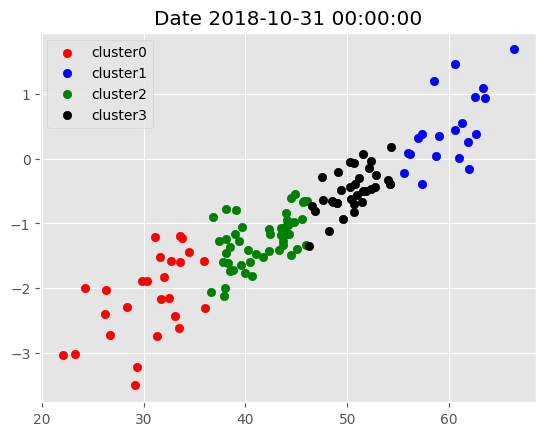

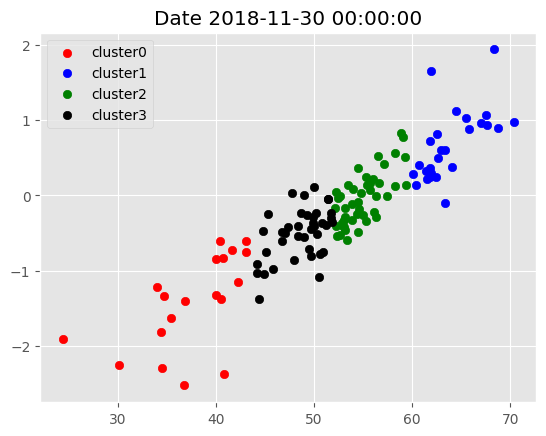

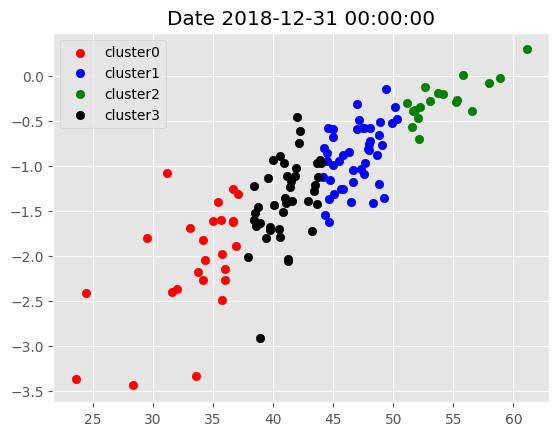

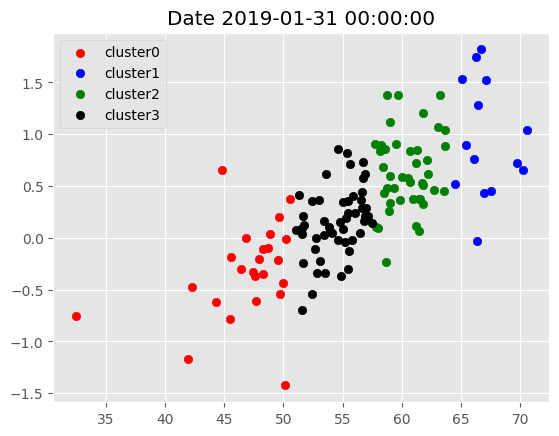

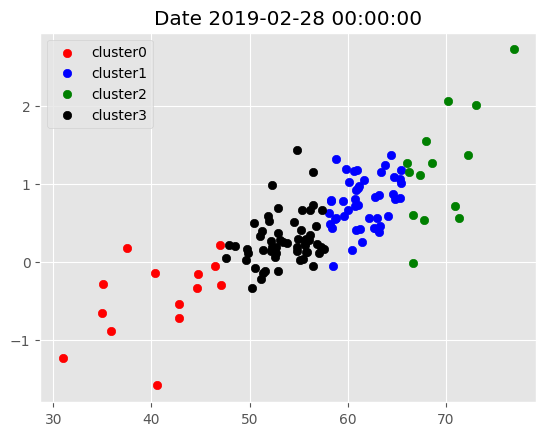

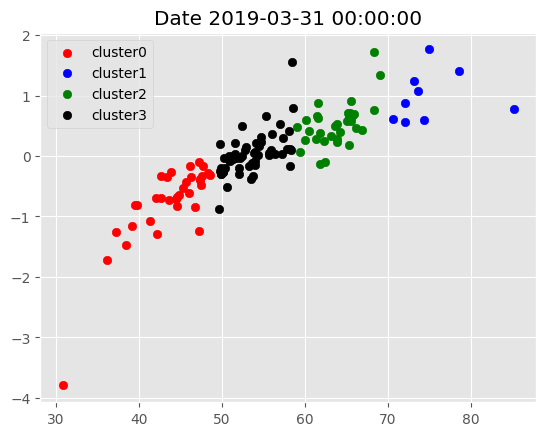

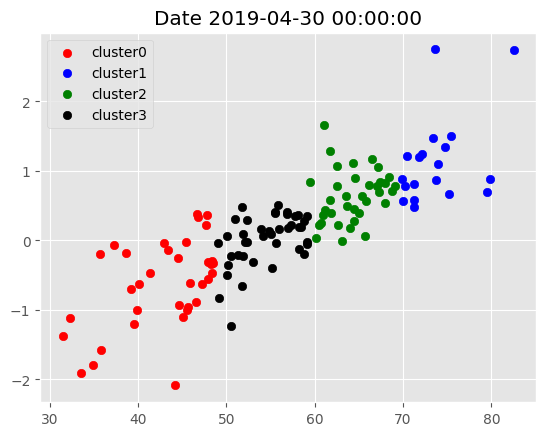

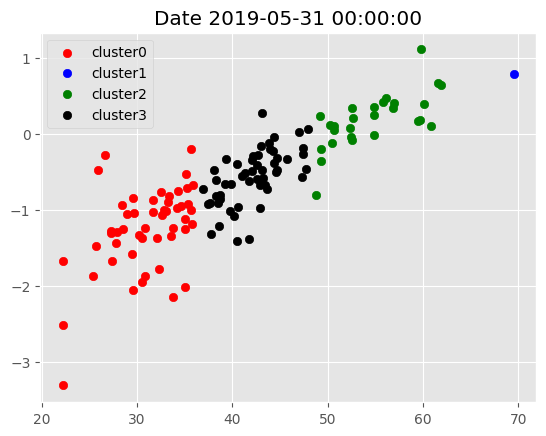

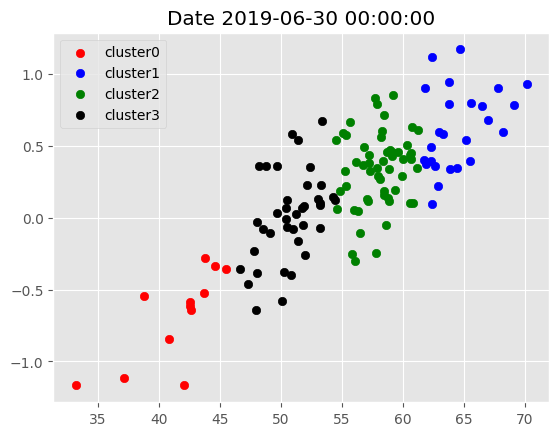

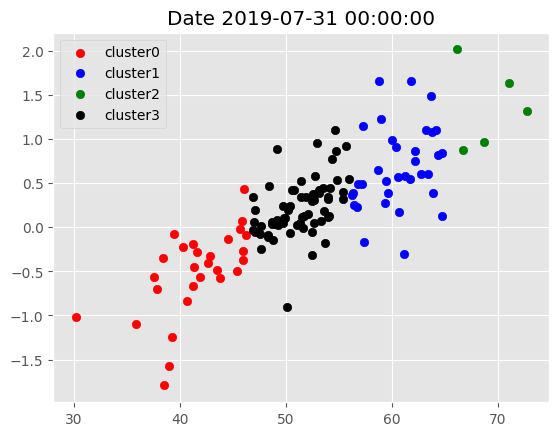

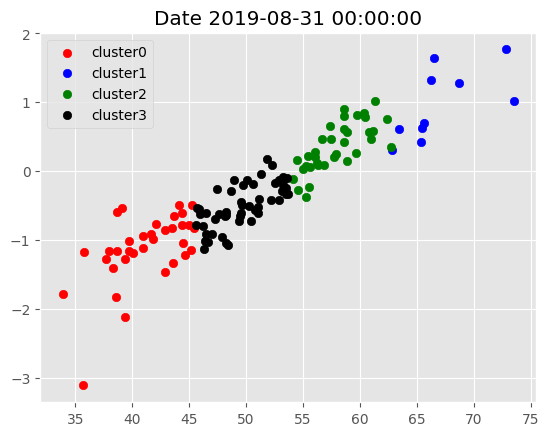

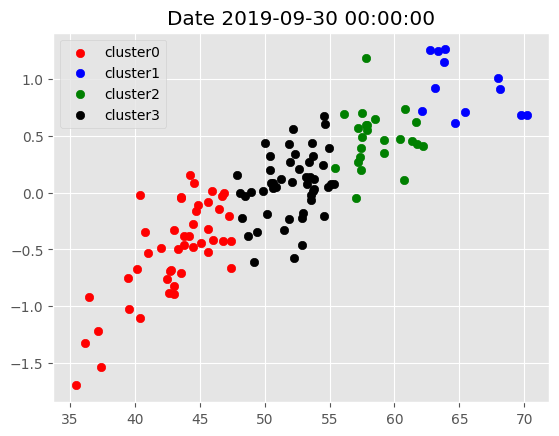

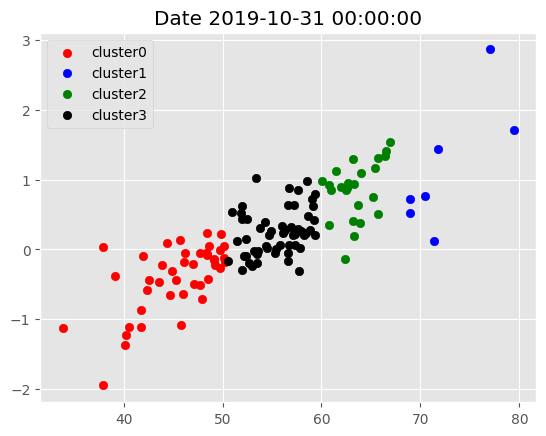

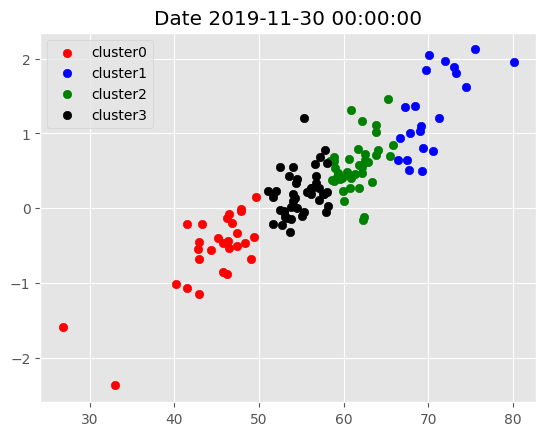

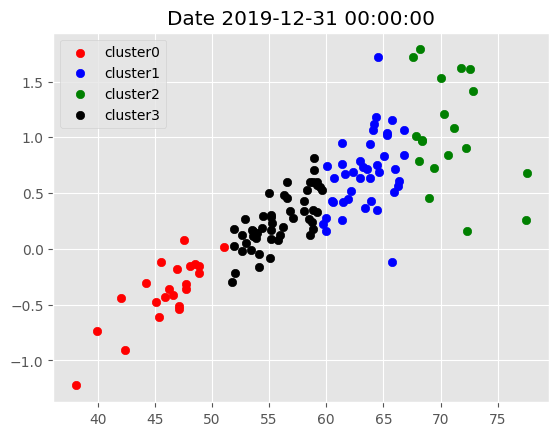

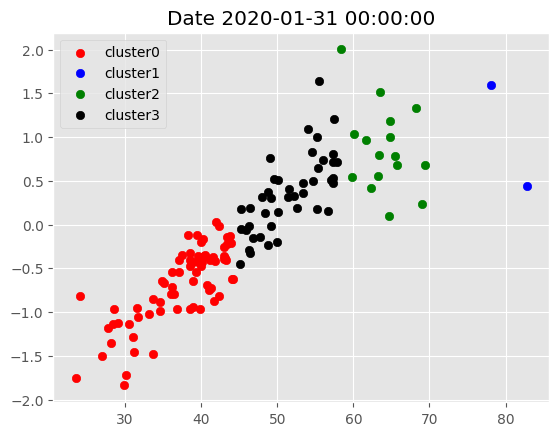

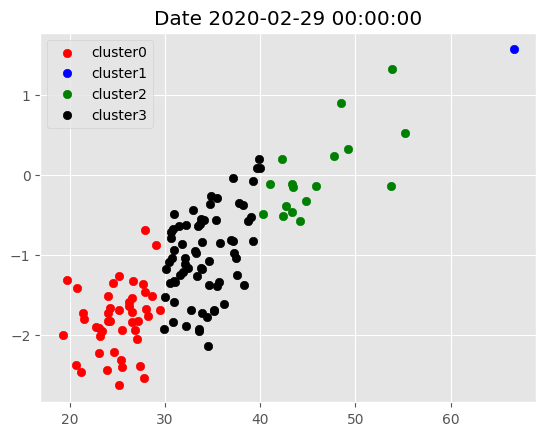

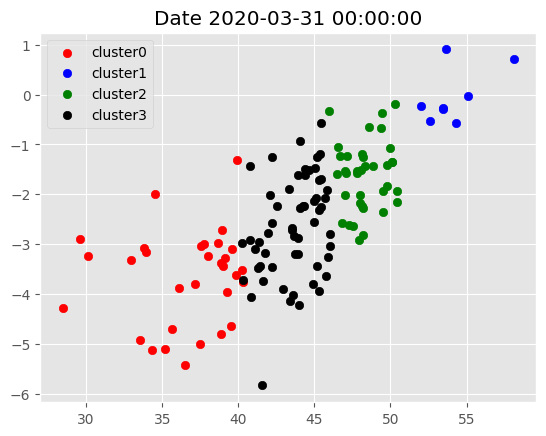

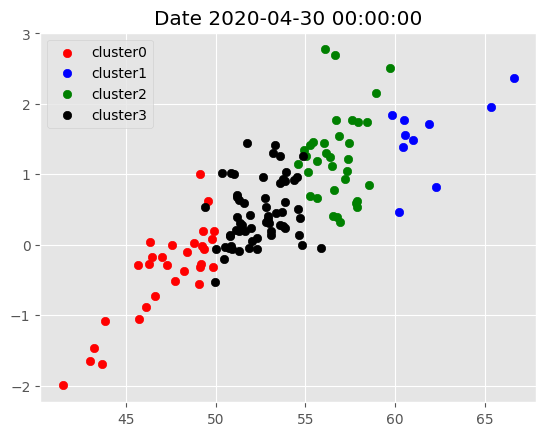

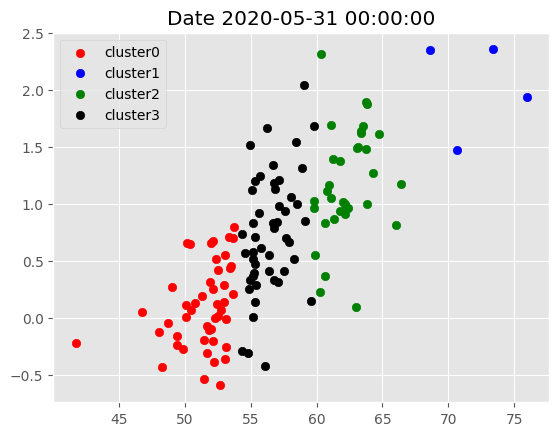

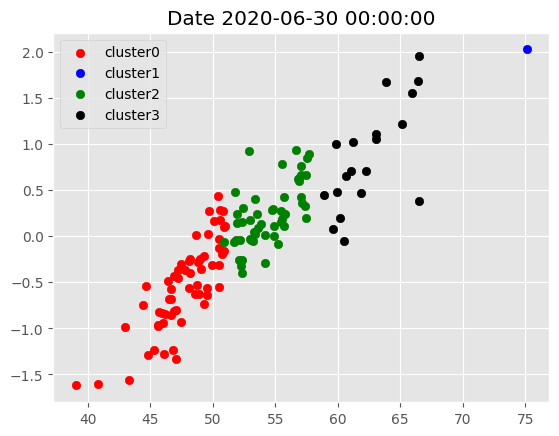

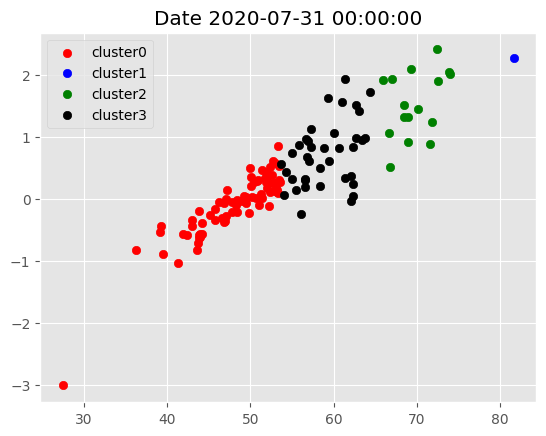

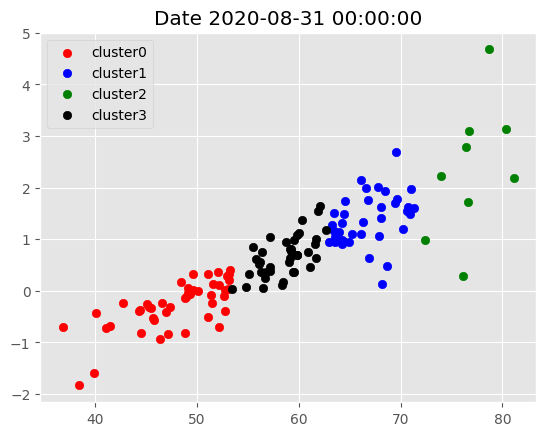

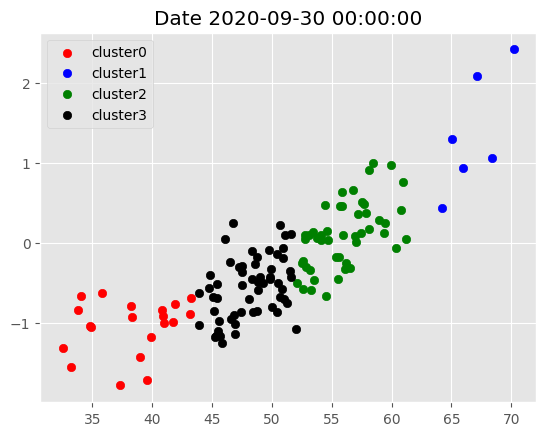

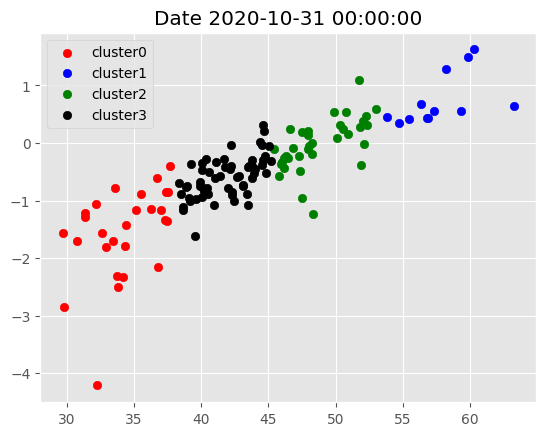

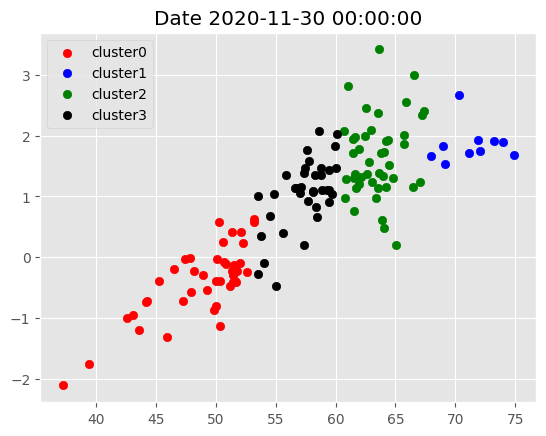

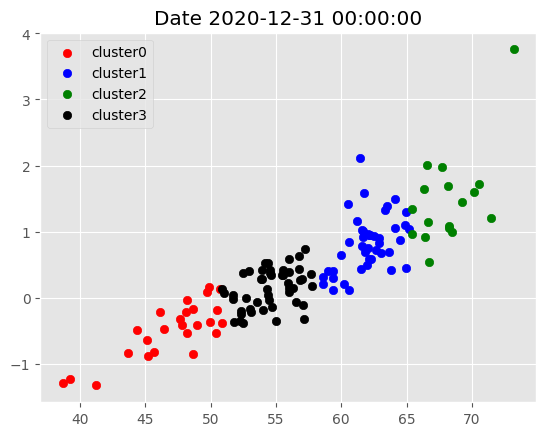

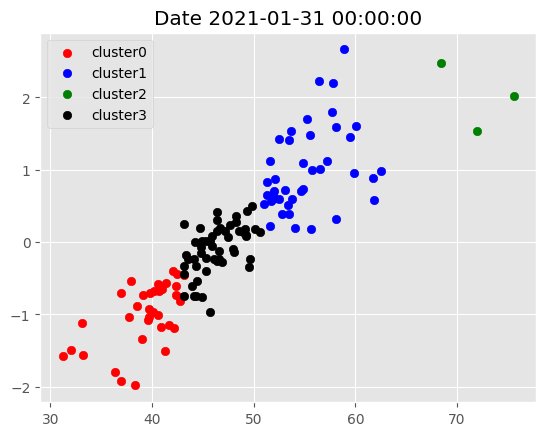

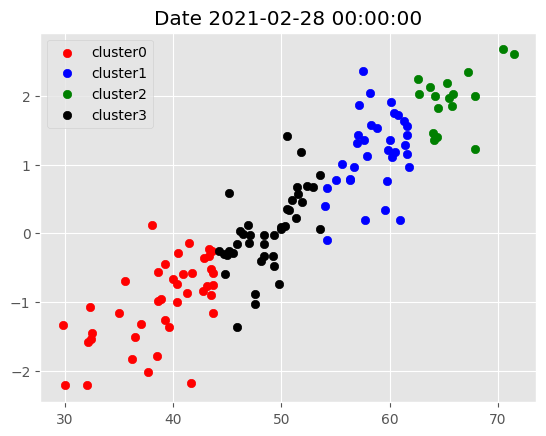

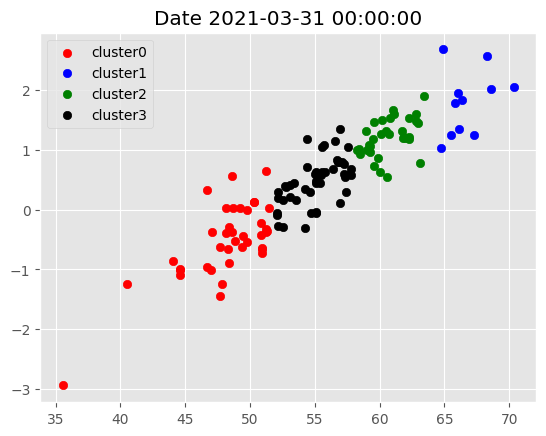

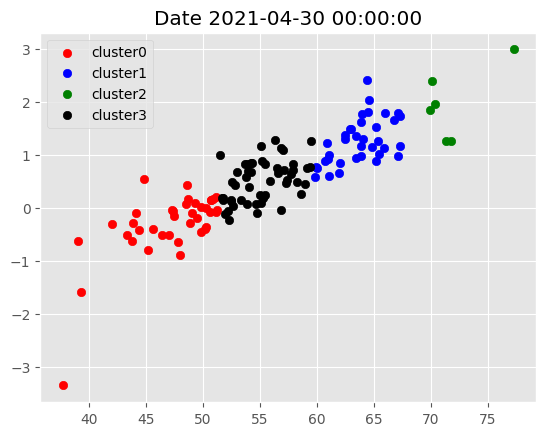

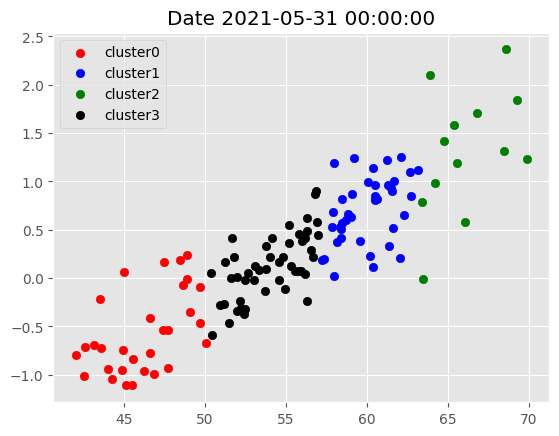

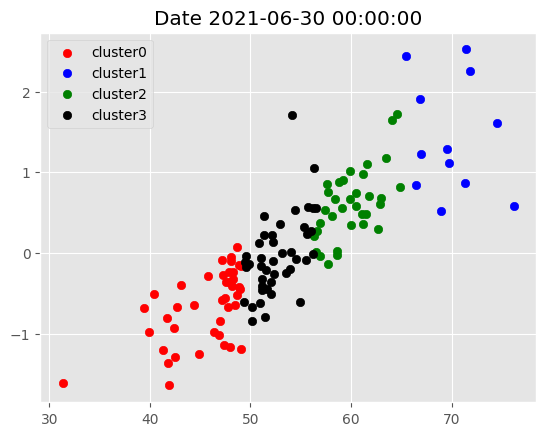

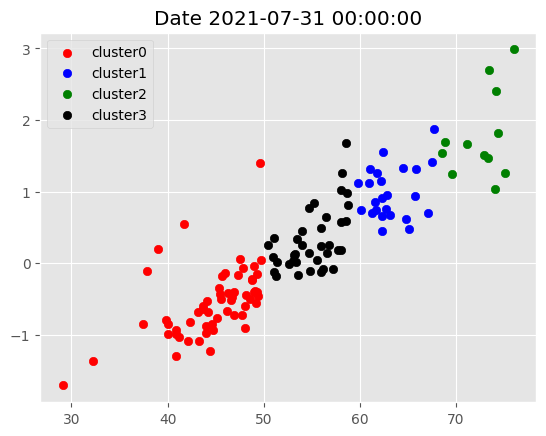

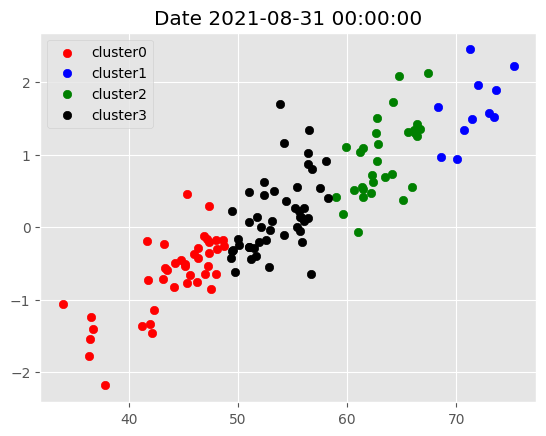

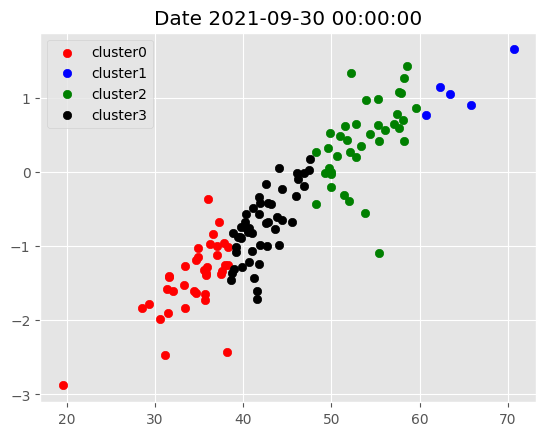

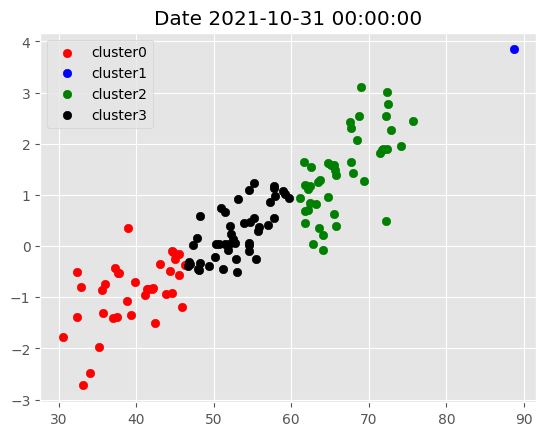

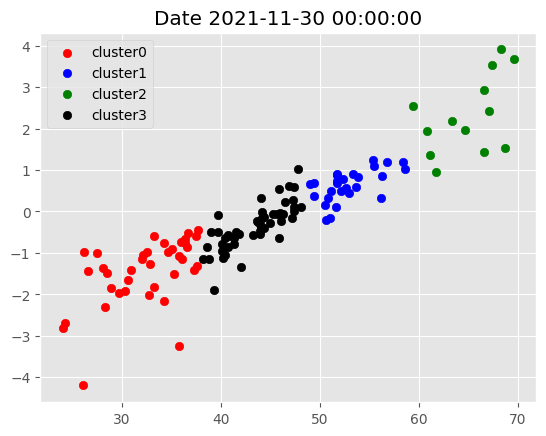

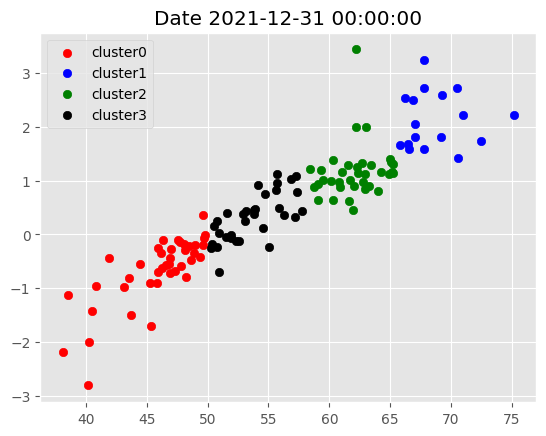

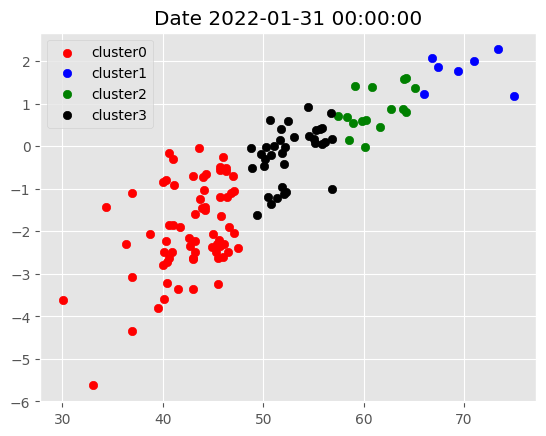

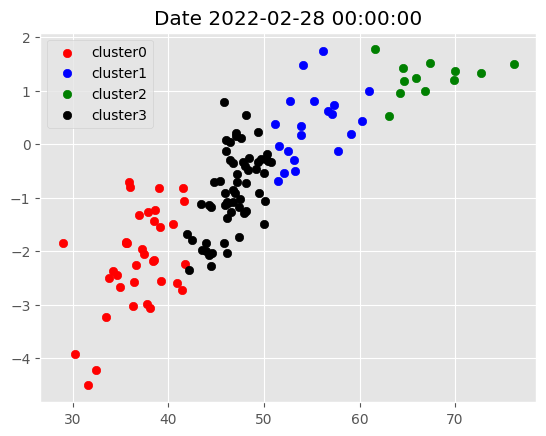

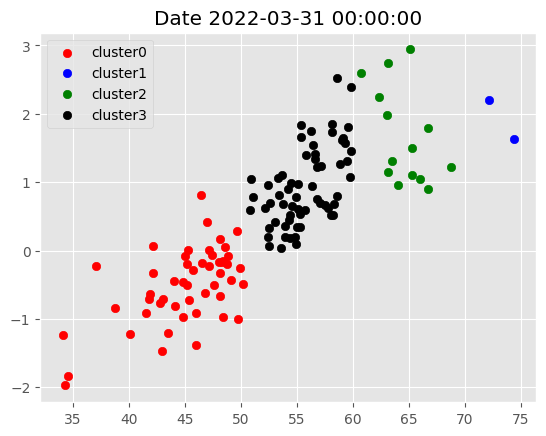

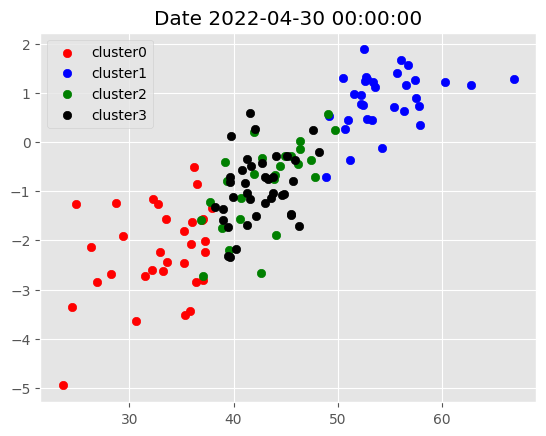

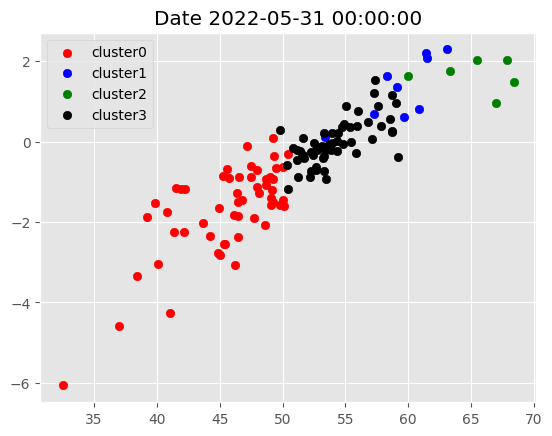

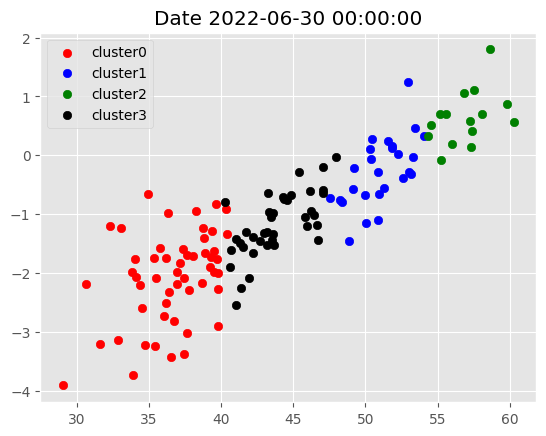

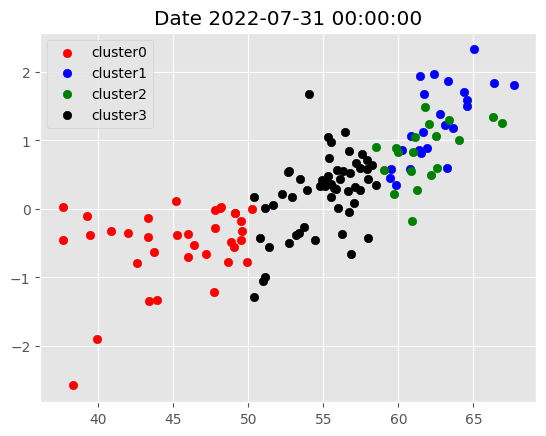

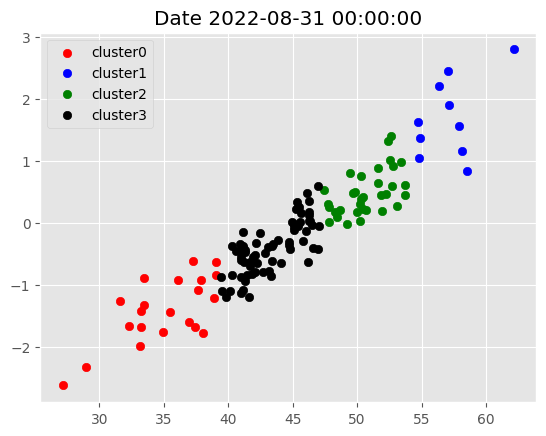

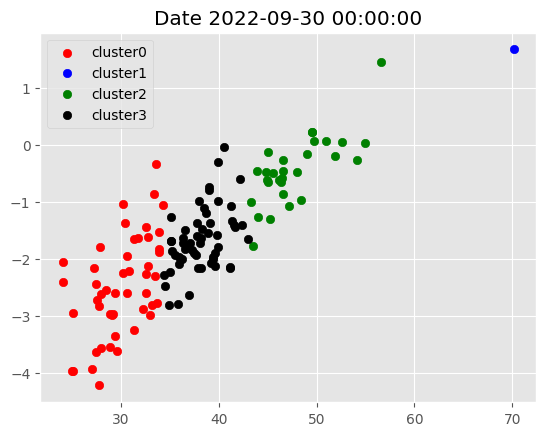

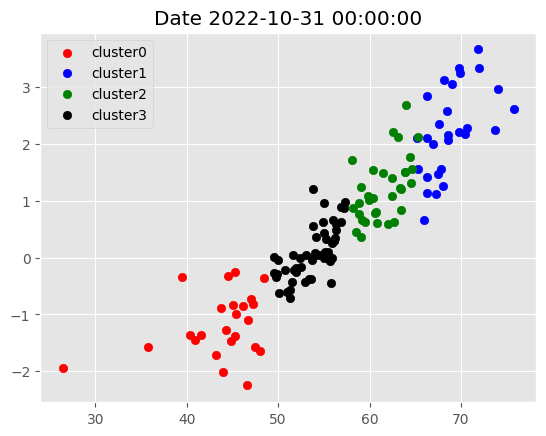

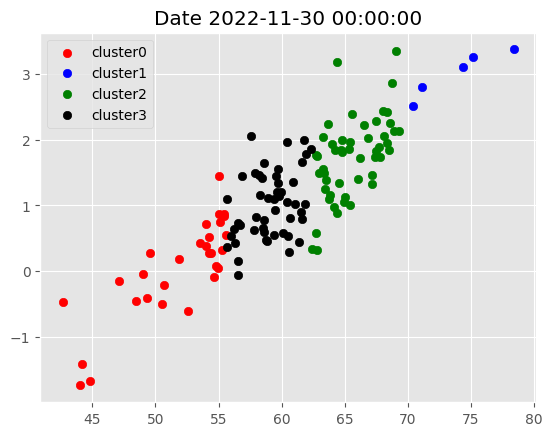

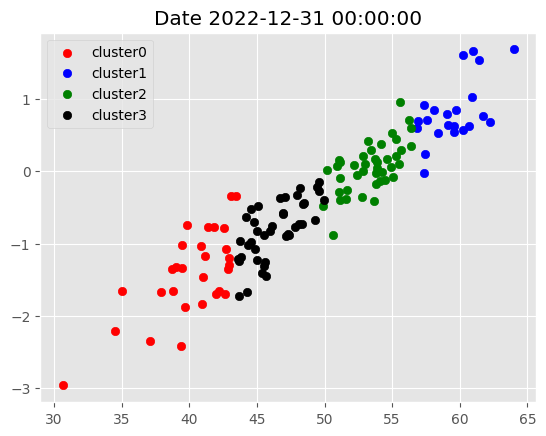

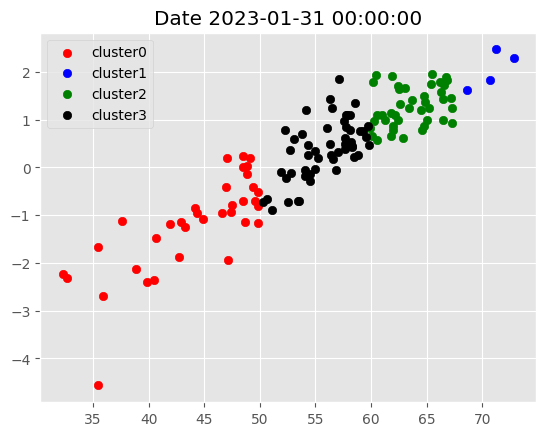

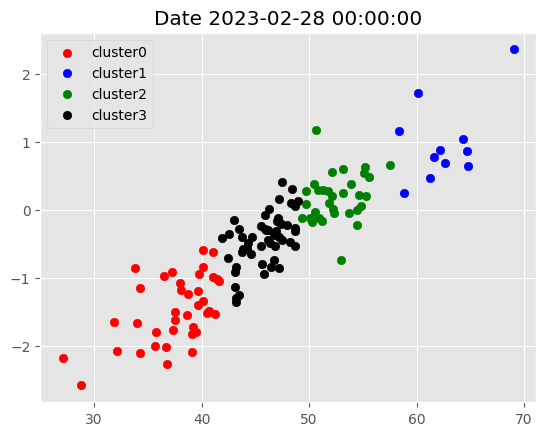

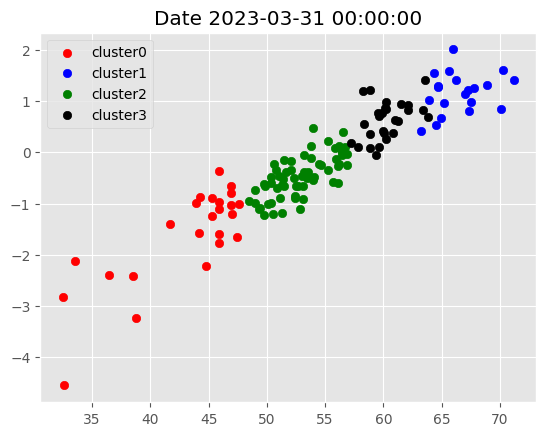

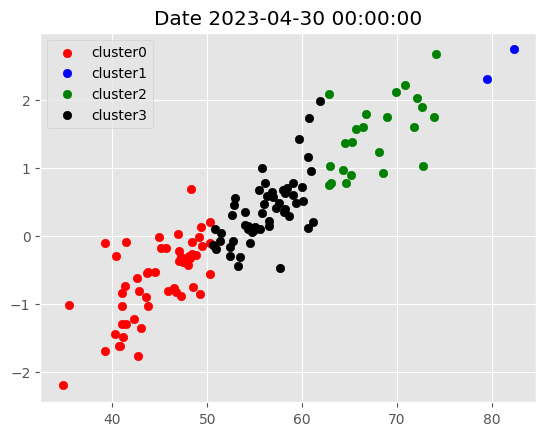

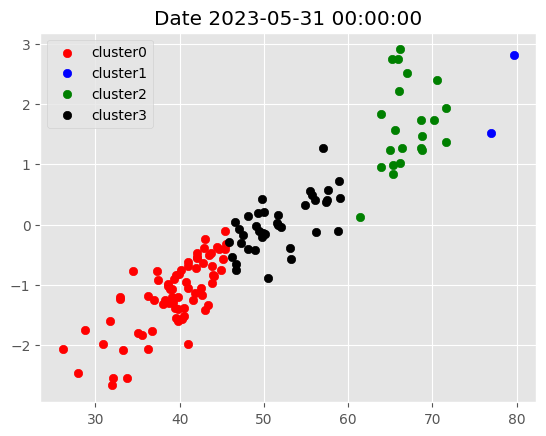

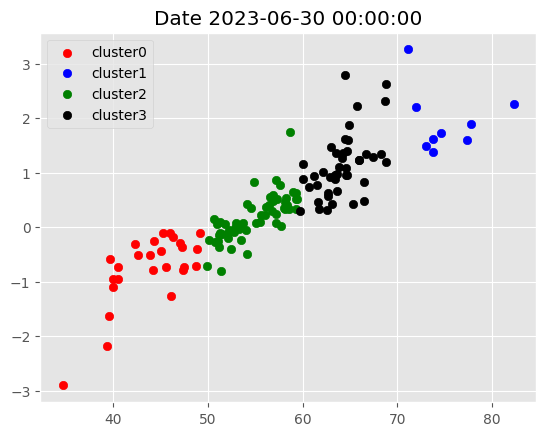

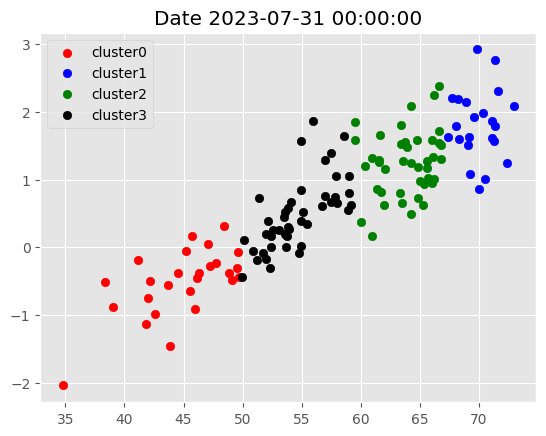

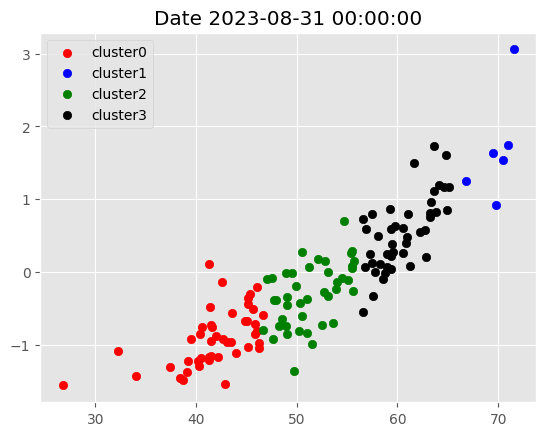

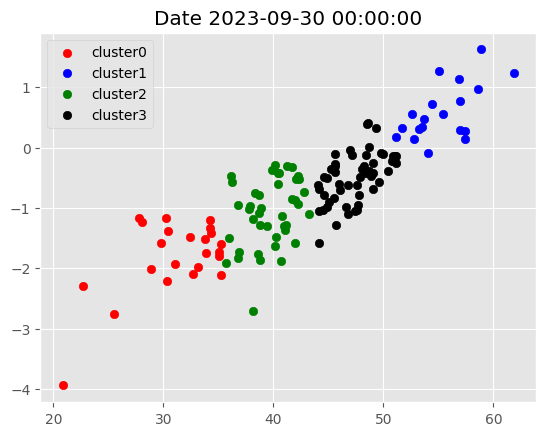

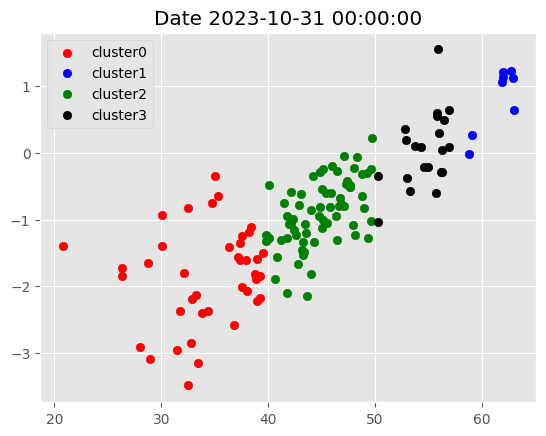

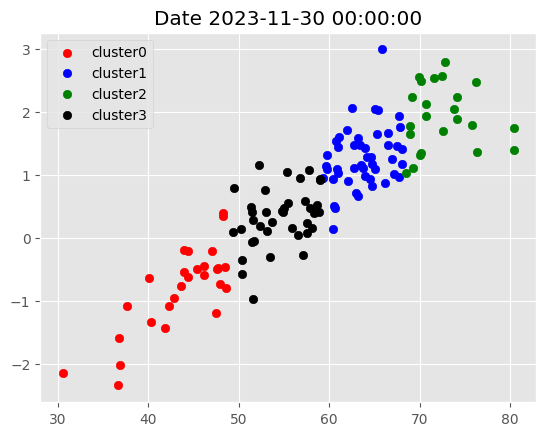

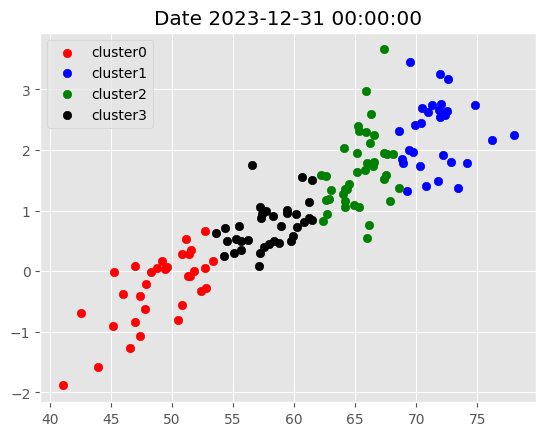

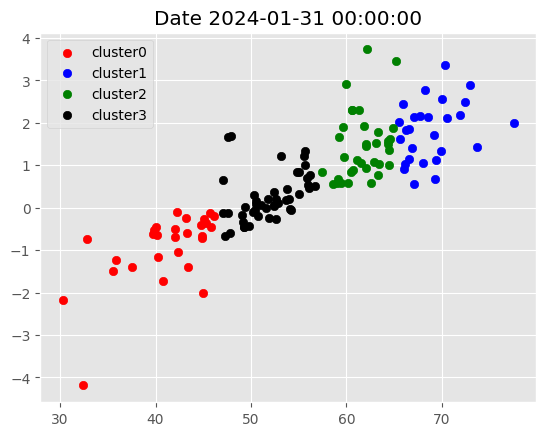

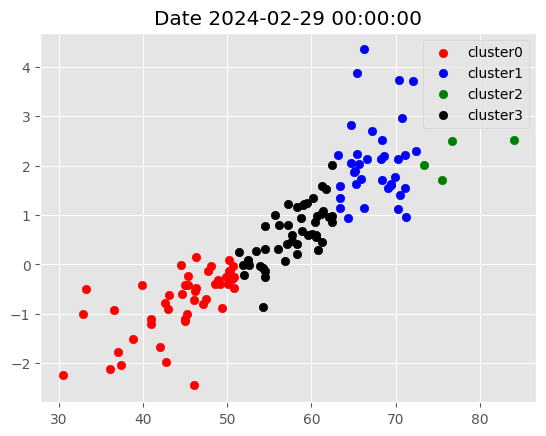

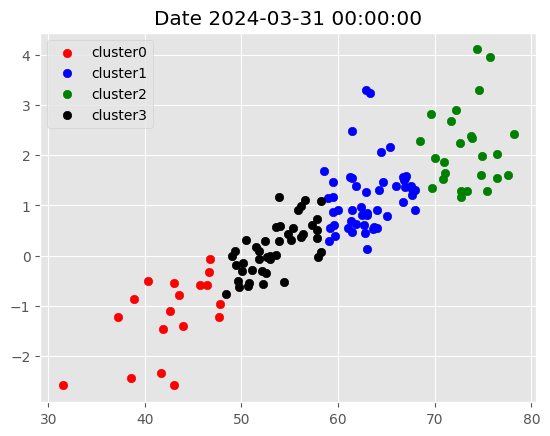

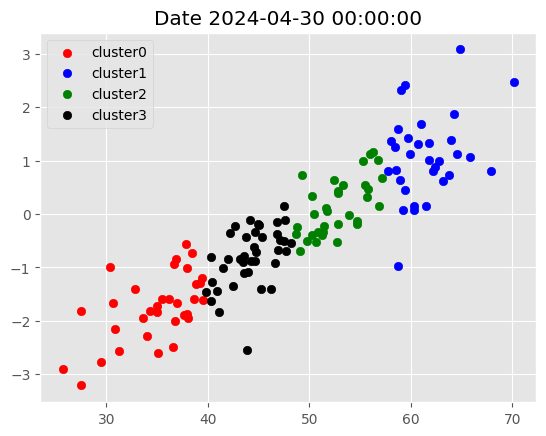

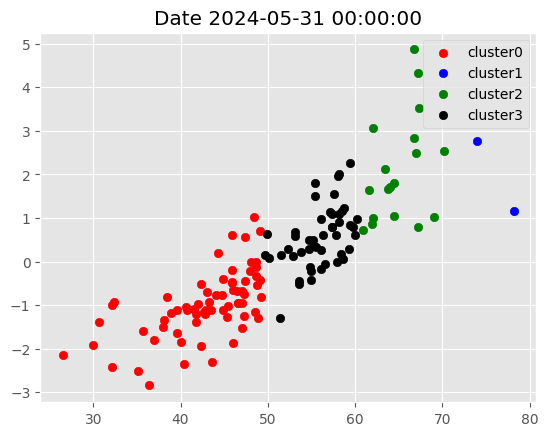

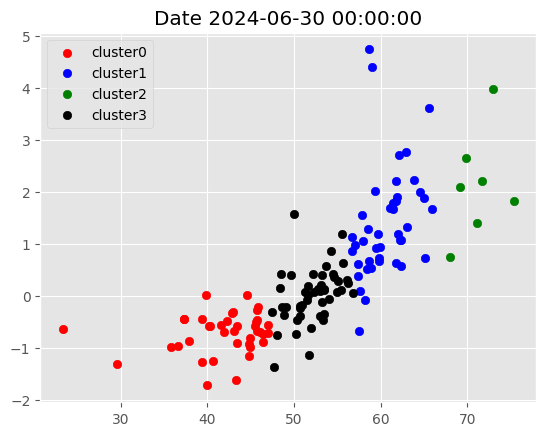

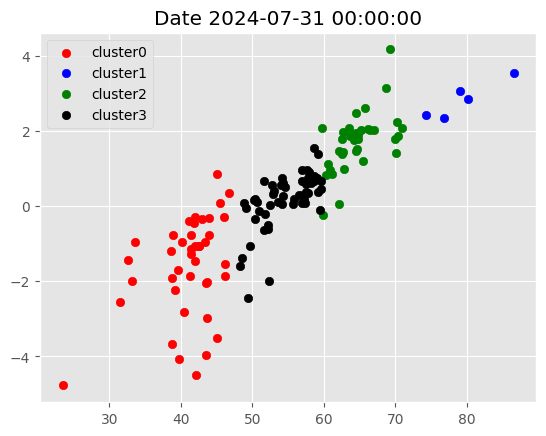

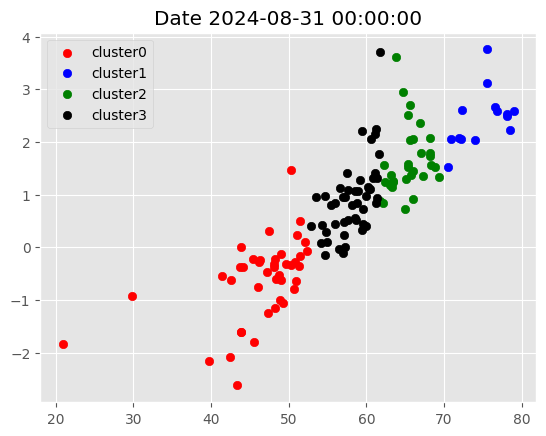

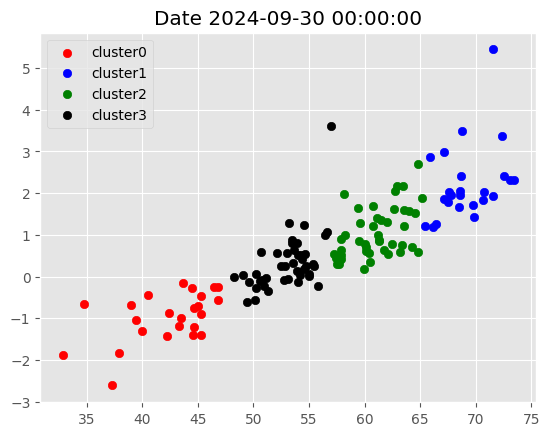

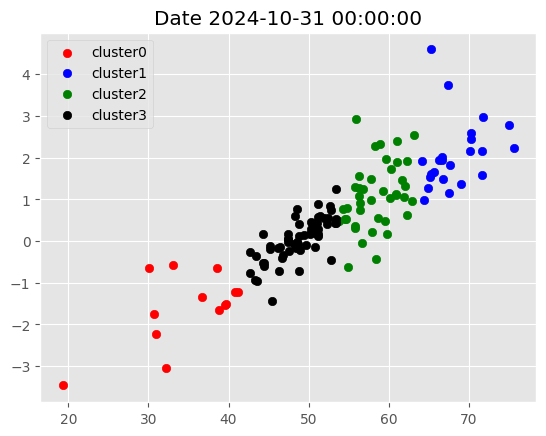

In [145]:
def plot_clusters(data):
    cluster0 = data[data['Cluster']==0]
    cluster1 = data[data['Cluster']==1]
    cluster2 = data[data['Cluster']==2]
    cluster3 = data[data['Cluster']==3]

    plt.scatter(cluster0.iloc[:,1], cluster0.iloc[:,6], color='red', label='cluster0')
    plt.scatter(cluster1.iloc[:,1], cluster1.iloc[:,6], color='blue', label='cluster1')
    plt.scatter(cluster2.iloc[:,1], cluster2.iloc[:,6], color='green', label='cluster2')
    plt.scatter(cluster3.iloc[:,1], cluster3.iloc[:,6], color='black', label='cluster3')

    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')
for i in data.index.get_level_values('Date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

# 7. Based on clusters pick stocks and form a portfolio on hte efficient frontier- maximizing sharpe ratio.
* Hypothesis: The cluster that remains at ~70 RSI should outperform other clusters


In [146]:
print(data[data['Cluster']==0]['RSI'].mean())
print(data[data['Cluster']==1]['RSI'].mean())
print(data[data['Cluster']==2]['RSI'].mean())
print(data[data['Cluster']==3]['RSI'].mean())


41.65029503633088
63.13767631893515
58.54682105708222
51.42485707559704


Cluster 1 seems to have the highest average RSI

In [154]:
filtered_df = data[data['Cluster'] == 1].copy()
filtered_df.index = filtered_df.index.set_levels(filtered_df.index.levels[0]+pd.DateOffset(1), level=0)
dates = filtered_df.index.get_level_values('Date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
fixed_dates


['CI',
 'CMCSA',
 'DG',
 'F',
 'GM',
 'JNJ',
 'KO',
 'KR',
 'MCD',
 'MO',
 'MRK',
 'PARA',
 'PG',
 'PM',
 'SBUX',
 'TSLA',
 'VZ',
 'WBA',
 'WMT',
 'YUM']

**Define Portfolio Optimizing Function**
* Use PyPortfolioOpt and EfficientFrontier optimizer to maximize the Shapre ratio
* To optimize weights supply 1 year data
* Apply single stock weight constaints (max 10%, min)

In [170]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optmize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound,0.1))
    weights = ef.max_sharpe()
    return ef.clean_weights()

In [158]:
stocks = data.index.get_level_values('Ticker').unique().tolist()
new_df = yf.download(tickers=stocks, start=data.index.get_level_values('Date').unique()[0]-pd.DateOffset(months=1))


,Garman_Klass_Volatility,RSI,bb_low,bb_mid,bb_high,ATR,macd,return_1,return_2,return_3,return_6,return_9,return_12,Mkt-RF,SMB,HML,RMW,CMA,RF,Cluster
Ticker,,,,,,,,,,,,,,,,,,,,
AAPL,-0.000440,50.232912,3.937351,3.975716,4.014081,-0.284486,-0.439139,-0.030477,-0.019453,0.048955,0.049216,0.031518,0.023037,0.008172,0.001678,-0.000405,0.002330,-0.031132,0.075000,3
ABBV,-0.033812,30.334090,4.099873,4.221550,4.343227,0.517470,-1.884407,-0.168082,-0.088049,-0.051576,-0.031893,-0.035715,-0.009087,0.019795,0.002657,0.003889,-0.010133,-0.008578,-0.034703,0
ABT,-0.003318,51.539032,4.108511,4.150519,4.192527,0.024980,-0.503587,-0.056387,0.017673,0.018394,0.030307,0.013075,0.021747,0.011525,-0.004794,-0.006225,-0.007100,0.004419,0.080551,3
ACN,-0.002060,44.756090,4.926109,4.990820,5.055531,-0.186971,-0.974973,-0.065449,-0.030053,-0.000564,0.008483,-0.000163,0.010026,0.009485,0.000785,-0.000574,0.002218,-0.005674,0.107350,2
ADBE,0.000288,46.518480,5.452778,5.520491,5.588203,0.476415,-0.729582,-0.089609,-0.034267,0.001469,0.017396,0.023294,0.028623,0.006851,-0.001826,-0.002533,-0.009357,-0.023729,-0.012732,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFC,-0.011143,48.618617,3.771889,3.810142,3.848394,0.852652,-0.667627,0.012747,-0.045943,-0.021829,0.006511,-0.020994,-0.002125,0.019406,0.000308,0.008826,-0.009089,0.001276,-0.165531,3
WMT,-0.005295,61.227067,3.362350,3.409321,3.456292,-0.082445,0.559407,0.067831,0.022795,0.041692,0.023179,-0.004778,0.013572,0.018049,-0.003499,-0.001916,0.014731,-0.000186,0.058984,1
WYNN,-0.000419,33.085966,4.490055,4.647285,4.804515,1.117290,-2.429896,-0.208248,-0.176488,-0.153602,-0.096135,-0.052585,-0.030132,-0.002395,0.011801,-0.017464,-0.005448,0.010759,-1.146324,0


* Calculate Daily returns of stocks that could be in the portfolio
* Then loop over each month, select the stocks for that month and calculate the weigths for the next month
* If sharpe-maximization fails for a certain month, apply equally distributed weights
* Calculate each day return of the portfolio

In [212]:
returns_df = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        try:
            weights = optmize_weights(prices=optimization_df, lower_bound=-0.1)
            weights = pd.DataFrame(weights,index=pd.Series(0))
        except:
            weights =  pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))], index=optimization_df.columns).T
            print(f'Sharpe Optimization failed for {start_date}')
        temp_df = returns_df[start_date:end_date]
        temp_df = temp_df.stack().to_frame('Return').reset_index(level=0)\
            .merge(weights.stack().to_frame('Weight').reset_index(level=0,drop=True), left_index=True, right_index=True)\
                .reset_index().set_index(['Date', 'Ticker'])
        temp_df.index.names = ['Date', 'Ticker']
        temp_df['Weighted-Return'] =   temp_df['Return']*temp_df['Weight']
        temp_df = temp_df.groupby(level=0)['Weighted-Return'].sum().to_frame('Strategy-Returns')
        portfolio_df = pd.concat([portfolio_df,temp_df], axis=0) 
    except Exception as e:
        print(e)


        CI  CMCSA       DG    F   GM  JNJ   KO       KR  MCD   MO  MRK  PARA  \
0  0.02191    0.1 -0.07247  0.0  0.1 -0.1  0.1 -0.01398  0.1  0.1  0.1  -0.1   

    PG   PM  SBUX     TSLA   VZ  WBA  WMT      YUM  
0  0.1  0.1   0.1  0.01643  0.1  0.1  0.1  0.04818  
   ABBV  ABT  AMGN      AXP   CI  DAL   GM      HCA  JNJ   KO  ...  PEP  \
0  -0.1 -0.1  -0.1 -0.07196  0.1  0.1  0.1 -0.04657  0.1  0.1  ...  0.1   

       PFE   PG  SBUX      TMO  UAL      UNH   VZ  WBA      YUM  
0 -0.09939  0.1   0.1 -0.03897  0.1  0.02735  0.1  0.1 -0.04372  

[1 rows x 26 columns]
   ADBE  AIG  AMAT  AMZN       BA      BAX     BIIB      BMY  BRK-B      CAT  \
0  -0.1 -0.1  -0.1  -0.1 -0.00187 -0.03495 -0.05508 -0.03892    0.1 -0.08864   

   ...  QCOM      SHW  TMO  TSLA      TXN    V     VRTX   VZ  WMT     WYNN  
0  ...  -0.1  0.03591  0.1   0.1  0.09482  0.1 -0.00281  0.1  0.1  0.05013  

[1 rows x 45 columns]
   AMT   BA  BAX  CHTR  EBAY  ELV      GE     IBM  LUV  MDLZ  META  PANW  \
0  0.1  0.1  

<Axes: xlabel='Date'>

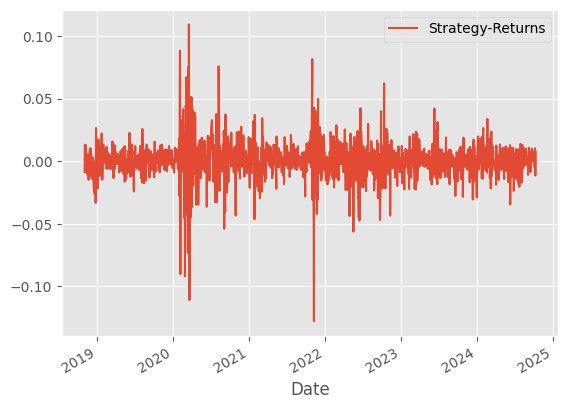

In [213]:
portfolio_df.plot()


# 8. Visualize Portfolio Returns and compare to S&P 500

In [217]:
spy = yf.download(tickers="SPY", start='2019-01-01', end=dt.date.today())
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold'}, axis =1)
portfolio_df.index = portfolio_df.index.tz_localize(None)
portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)
portfolio_df

[*********************100%***********************]  1 of 1 completed

            SPY Buy&Hold
Date                    
2019-01-03     -0.024152
2019-01-04      0.032947
2019-01-07      0.007854
2019-01-08      0.009351
2019-01-09      0.004663
...                  ...
2024-10-07     -0.009082
2024-10-08      0.009413
2024-10-09      0.006903
2024-10-10     -0.001752
2024-10-11      0.005970

[1454 rows x 1 columns]


,Strategy-Returns,SPY Buy&Hold
Date,,
2019-01-03,-0.021590,-0.024152
2019-01-04,0.017401,0.032947
2019-01-07,-0.001568,0.007854
2019-01-08,0.016848,0.009351
2019-01-09,-0.007093,0.004663
...,...,...
2024-10-07,-0.005134,-0.009082
2024-10-08,0.010262,0.009413
2024-10-09,0.006186,0.006903


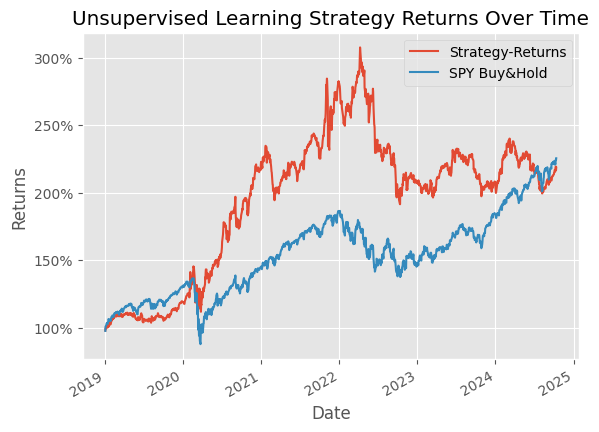

In [232]:

import matplotlib.ticker as mtick
plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())
portfolio_cumulative_return
portfolio_cumulative_return.plot()
plt.title('Unsupervised Learning Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Returns')
plt.show()